<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="3"><b>Bachelor Thesis</b> </font>
</div>
<br>
<div align="center"> 
  <font size="5">
      <b>WinnER: A Winner-Take-All Hashing-Based Unsupervised Model <br>for Entity Resolution Problems<br></b> 
    </font>
     <hr>
     <font size="4">
        Study on CENSUS data set 
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos</b>, BS Student at NKUA 
     </font>
</div>
<div align="center"> 
    <font size="4">
     <b> Alex Delis</b>,  Professor NKUA <br> 
     <b> Vassilios Verykios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Code injection__

## Import of libraries

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special
import igraph
import networkx as nx
import itertools 
import sklearn
import plotly.express as px
import logging
import sys
import optuna
import plotly

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming,jaccard
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime
from sklearn.decomposition import PCA 
from numpy.linalg import svd

# plt.style.use('seaborn-white') # plot style
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Main model dependency

In [3]:
from model import WinnER, customClassificationReport, report

## Utilities

In [4]:
from utils.mmd2 import MMD2, myMMD2
from plot.heatmap import myHeatmap
from plot.confusion_matrix import create_ConfusionMatrix
from plot.dimension_reduction import SpaceVisualization2D, SpaceVisualization3D, SpaceVisualizationEmbeddings2D, SpaceVisualizationEmbeddings3D
from plot.heatmap import similarityProbsHeatMap, similarityProbsHeatMapWithClusters

### Dataset utils

In [5]:
from datasets.common.create_dataset import createDataset, createTrueLabels
from utils.grid_search import GridSearch

### Custom metrics

In [6]:
from utils.metrics import spearman_footrule_distance, kendall_top_k, rbo


# __Dataset injection__

## Load data from Drive in Colab

In [7]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fp = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fp_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

In [24]:
CENSUS_groundTruth = pd.read_csv(os.path.abspath("../data/censusIdDuplicates.csv"),sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(os.path.abspath("../data/censusProfiles.csv"),sep='|')
CENSUS

,Entity Id,attr1,attr2,attr3,attr4,attr5,Unnamed: 6
0,0,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
1,1,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
2,2,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
3,3,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
4,4,AQUENDO,CLARA,J,666,STARKEY,NaN
...,...,...,...,...,...,...,...
836,836,WILLIAM,SHERRY,V,510,WOODHAVEN,NaN
837,837,WRIGHT,BRYAN,NaN,307,WOODHAVEN,NaN
838,838,WRIGHT,MAXINE,H,307,WOODHAVEN,NaN
839,839,YATES,CHANSE,E,403,WOODHAVEN,NaN


In [25]:
CENSUS_groundTruth.sort_values('id2')

,id1,id2
302,5,451
17,6,452
74,7,453
130,8,454
178,9,455
...,...,...
42,446,836
54,440,837
110,441,838
97,447,839


# __Dataset attribute analysis__

In [26]:
DATASET_NAME = 'CENSUS'

## Data set shuffle (Optional)

In [27]:
dataset_shuffled = CENSUS.sample(frac=1).reset_index(drop=True)
# dataset_shuffled

## Pre-process

In [28]:
fields = list(CENSUS.columns)
data, true_matrix = createDataset(CENSUS, CENSUS_groundTruth, fields, 'Entity Id')

Creating groundtruth matrix: 100%|██████████| 344/344 [00:00<00:00, 6254.02it/s]


__Clique construction for visualization purposes__

In [29]:
labels_groundTruth, numOfObjWithoutDups, groups = createTrueLabels(CENSUS['Entity Id'].tolist(), CENSUS_groundTruth)            
data_length = [ len(x) for x in data ]

## Attributes

In [30]:
specs = {
    'Objects without any duplicates' : CENSUS.shape[0] - sum([len(x) for x in groups]), 
    'Objects with at least one duplicate' : sum([len(x) for x in groups]),
    'Total number of objects' : CENSUS.shape[0], 
    'Mean size of clusters' : np.average([len(x) for x in groups]),
    'Number of ER clusters' : len(groups),
    'Dataset size' : len(data), 
    'Average length' : np.mean(data_length), 
    'Min length' : min(data_length), 
    'Max length' : max(data_length),
    'Median length' : np.median(data_length)
}
specsCENSUSDf = pd.DataFrame(list(specs.items()), columns=['Spec','#count'])
specsCENSUSDf[['#count']] = specsCENSUSDf[['#count']].astype(int)
specsCENSUSDf

,Spec,#count
0,Objects without any duplicates,170
1,Objects with at least one duplicate,671
2,Total number of objects,841
3,Mean size of clusters,2
4,Number of ER clusters,333
5,Dataset size,841
6,Average length,30
7,Min length,18
8,Max length,45
9,Median length,31


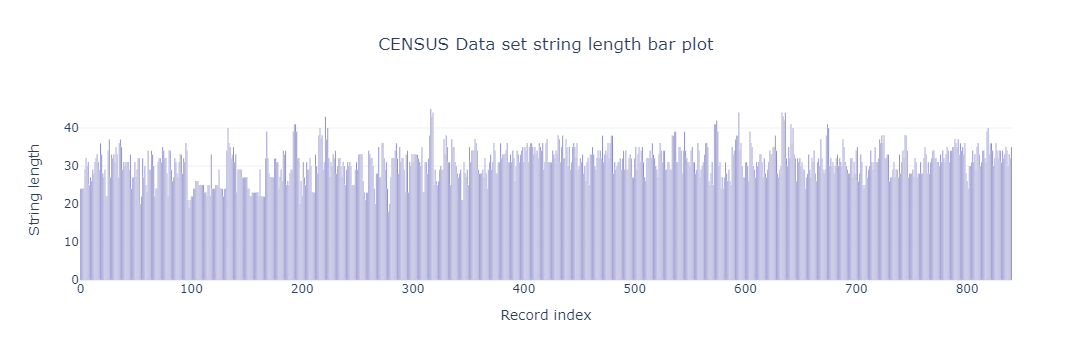

In [31]:
df = pd.DataFrame({"Record index":range(0,len(data_length),1),"String length":data_length})
fig = px.bar(df, x= "Record index", y="String length", title= DATASET_NAME + " Data set string length bar plot",template='plotly_white')
fig.update_traces(marker_color='darkblue', opacity=1.0)
fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title(DATASET_NAME + " Data set string length bar plot")
fig.savefig("strlennCENSUS.png")
plt.show()

# Optuna search

## Euclid-Jaccard with 3-grams and char-tokenization

In [ ]:
euclid_jaccard_char_3 = optuna.create_study(
    directions = ["maximize"],
    study_name = "euclid_jaccard_char_3_CENSUS", 
    storage    = "sqlite:///optuna_tuning/WinnER_Experiments_v3.db", 
    load_if_exists = True
)

Trials dataframe (Optuna default)

In [ ]:
euclid_jaccard_char_3.trials_dataframe(attrs=("number", "value", "params", "state"))

In [ ]:
plot_optimization_history(euclid_jaccard_char_3)

In [ ]:
# plot_intermediate_values(euclid_jaccard_char_3)

In [ ]:
plot_parallel_coordinate(euclid_jaccard_char_3)

In [ ]:
plot_parallel_coordinate(euclid_jaccard_char_3, params=["number_of_permutations", "similarity_threshold"])

In [ ]:
plot_contour(euclid_jaccard_char_3)

In [ ]:
plot_contour(euclid_jaccard_char_3, params=["number_of_permutations", "similarity_threshold"])

In [ ]:
plot_slice(euclid_jaccard_char_3,  params=["number_of_permutations", "similarity_threshold", "max_dissimilarity_distance", "window_size", "max_num_of_clusters"])

In [ ]:
plot_param_importances(euclid_jaccard_char_3)

In [ ]:
plot_edf(euclid_jaccard_char_3)

In [ ]:
optuna.visualization.plot_param_importances(
    euclid_jaccard_char_3, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

### Study statistics

In [ ]:
euclid_jaccard_char_3_DF = pd.read_csv(
    os.path.abspath("./optuna_tuning/csv/euclid_jaccard_char_3_CENSUS.csv")
)
print(euclid_jaccard_char_3_DF.columns)

In [ ]:
ltable = euclid_jaccard_char_3_DF[['trial_id','Recall','F1','Precision','Accuracy', 'Time']].sort_values(by=['F1','Recall','F1'], ascending=False).head(10)
ltable = ltable.sort_values(by=['Recall','F1'], ascending=False)
ltable['Time'] = ltable['Time'].astype('datetime64[s]').dt.strftime("%M:%S")
print(ltable.to_latex(index=False))



In [ ]:
fig = px.parallel_coordinates(
    euclid_jaccard_char_3_DF[[ 'diffObjectsComparedSuccess',
       'sameObjectsCompared', 'sameObjectsComparedSuccess', 'selectedNumOfPrototypes', 'number_of_permutations', 'num_of_comparisons', 'Recall']], color="Recall", 
    # labels={"num_of_comparisons": "num_of_comparisons", "diffObjectsComparedSuccess": "diffObjectsComparedSuccess"},
    color_continuous_scale=px.colors.sequential.RdBu, 
    color_continuous_midpoint=2
)
fig.show()

In [ ]:
fig = px.parallel_coordinates(
    euclid_jaccard_char_3_DF[[ 'max_dissimilarity_distance', 'max_num_of_clusters', 'selectedNumOfPrototypes', 'Recall', 'Accuracy']], color="Recall", 
    # labels={"num_of_comparisons": "num_of_comparisons", "diffObjectsComparedSuccess": "diffObjectsComparedSuccess"},
    color_continuous_scale=px.colors.sequential.RdBu, 
    # color_continuous_midpoint=2
)
fig.show()

In [ ]:
# fig = px.parallel_categories(
#     euclid_jaccard_char_3_DF[[ 'diffObjectsComparedSuccess', 'sameObjectsCompared', 'sameObjectsComparedSuccess', 'selectedNumOfPrototypes', 'number_of_permutations', 'num_of_comparisons', 'Recall', 'trial_id']], 
#     color="Recall",
#     color_continuous_scale=px.colors.sequential.Inferno
# )
# fig.show()

In [ ]:
fig = px.scatter(
    euclid_jaccard_char_3_DF[['F1', 'Time', 'diffObjectsComparedSuccess', 'sameObjectsCompared', 'sameObjectsComparedSuccess', 'selectedNumOfPrototypes', 'number_of_permutations', 'num_of_comparisons', 'Recall', 'trial_id']], 
    x="diffObjectsComparedSuccess", 
    y="sameObjectsComparedSuccess", 
    size="num_of_comparisons", 
    color="Recall",
    # hover_name="F1", 
    log_x=True, 
    color_continuous_scale=px.colors.sequential.RdBu_r, 
    size_max=10,
    template='plotly_white',
    labels={
         "diffObjectsComparedSuccess": "Different papers compared with success",
         "sameObjectsComparedSuccess": "Same papers compared with success",
     }
)
fig.show()

In [ ]:
plot_df = euclid_jaccard_char_3_DF[['F1', 'Time', 'diffObjectsComparedSuccess', 'sameObjectsCompared', 'sameObjectsComparedSuccess', 'selectedNumOfPrototypes', 'number_of_permutations', 'num_of_comparisons', 'Recall', 'trial_id']].sort_values('Recall', ascending=True).tail(10)

px.scatter(
    plot_df, 
    x="diffObjectsComparedSuccess", 
    y="sameObjectsComparedSuccess", 
    # size="num_of_comparisons", 
    # color="Time",
    # hover_name="F1", 
    animation_frame="Recall", 
    animation_group="number_of_permutations",
    # facet_col="Recall",
    log_x=True, 
    template='plotly_white'
    # size_max=10, 
    # range_x=[1000,10000000], 
    # range_y=[10,100]
)
# fig.show()

In [ ]:
fig = px.parallel_coordinates(
    euclid_jaccard_char_3_DF[[ 'window_size', 'number_of_permutations', 'averageBucketSize','similarityTime', 'Recall', 'Accuracy']], color="Recall", 
    # labels={"num_of_comparisons": "num_of_comparisons", "diffObjectsComparedSuccess": "diffObjectsComparedSuccess"},
    color_continuous_scale=px.colors.sequential.RdBu, 
    # color_continuous_midpoint=2
)
fig.show()

### Best model

In [ ]:
best_params = euclid_jaccard_char_3_DF[euclid_jaccard_char_3_DF['trial_id'] == 12].to_dict('records')[0]

In [ ]:
winnER = WinnER(verbose_level=1)
winnER.set_params(best_params)
winnER.hackForDebug(labels_groundTruth, true_matrix)
winnER.fit(data)
winnER.evaluate(winnER.mapping_matrix, true_matrix)

### Space Visualization

In [ ]:
SpaceVisualization2D(winnER.Embeddings, winnER.prototypeArray)

In [ ]:
SpaceVisualization2D(winnER.Embeddings, winnER.prototypeArray, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(winnER.Embeddings, winnER.prototypeArray)

In [ ]:
SpaceVisualization3D(winnER.rankedVectors,winnER.prototypeArray, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(winnER.rankedVectors, winnER.prototypeArray, withPlotly = True, decompositionMenthod='MDS')

In [ ]:
SpaceVisualizationEmbeddings2D(
    winnER.Embeddings, labels_groundTruth, withPlotly=True, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    winnER.rankedVectors, labels_groundTruth, withPlotly=True, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    winnER.rankedVectors, labels_groundTruth, withPlotly=True, decompositionMenthod='MDS'
)

__MMD error between distribution of Prototypes and whole Dataset__

In [ ]:
myMMD2(winnER)